<a href="https://colab.research.google.com/github/Kryko7/Learning-Paradigms-Tranfer-Learning/blob/main/transfer_learning_classifying_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Phase

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

## Set Up Device for GPU/CPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Preprocessing
Here we define transformations for the training and validation sets. Since ResNet18 expects inputs of size 224x224 with 3 channels, we resize the MNIST images accordingly and normalize them for better convergence during training.

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),  # ResNet requires input size 224x224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # MNIST has a single channel, so mean and std for 1 channel
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}

## Load the MNIST Dataset
We load the MNIST dataset using PyTorch's datasets module. The dataset is divided into training and validation sets.

In [4]:
data_dir = 'mnist_data'

# Use ImageFolder structure or directly use MNIST dataset
image_datasets = {x: datasets.MNIST(root=data_dir, train=True if x == 'train' else False,
                                    download=True, transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5061355.02it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 65275.59it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1095962.46it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4561908.23it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, cmap="gray")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

## Load Pre-trained ResNet18 Model
We use a pre-trained ResNet18 model and modify its architecture to suit the MNIST dataset. This is where transfer learning comes., as we adapt a model trained on a different dataset (ImageNet) for our task.

In [6]:
# Load pre-trained ResNet18 model
model_ft = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept 1 channel (grayscale) input
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modify the final fully connected layer to output 10 classes (for MNIST)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

# Move the model to GPU if available
model_ft = model_ft.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 226MB/s]


## Define Loss Function, Optimizer, and Learning Rate Scheduler
We use CrossEntropyLoss for classification, the SGD optimizer with momentum, and a learning rate scheduler to adjust the learning rate as training progresses.

In [7]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Optimize only the final layer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler to decay the learning rate by 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train the Model
This function trains the model on the training set and evaluates it on the validation set. It also keeps track of the best performing model based on validation accuracy.

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

# Save the trained model
torch.save(model_ft.state_dict(), 'mnist_resnet18.pth')

Epoch 0/9
----------
train Loss: 0.1340 Acc: 0.9633
val Loss: 0.0411 Acc: 0.9870
Epoch 1/9
----------
train Loss: 0.0445 Acc: 0.9867
val Loss: 0.0293 Acc: 0.9915
Epoch 2/9
----------
train Loss: 0.0334 Acc: 0.9900
val Loss: 0.0309 Acc: 0.9900
Epoch 3/9
----------
train Loss: 0.0258 Acc: 0.9921
val Loss: 0.0263 Acc: 0.9911
Epoch 4/9
----------
train Loss: 0.0209 Acc: 0.9937
val Loss: 0.0263 Acc: 0.9922
Epoch 5/9
----------
train Loss: 0.0166 Acc: 0.9950
val Loss: 0.0265 Acc: 0.9916
Epoch 6/9
----------
train Loss: 0.0134 Acc: 0.9962
val Loss: 0.0227 Acc: 0.9933
Epoch 7/9
----------
train Loss: 0.0091 Acc: 0.9975
val Loss: 0.0226 Acc: 0.9930
Epoch 8/9
----------
train Loss: 0.0078 Acc: 0.9979
val Loss: 0.0209 Acc: 0.9932
Epoch 9/9
----------
train Loss: 0.0074 Acc: 0.9982
val Loss: 0.0208 Acc: 0.9934
Training complete in 6m 48s
Best val Acc: 0.9934


# Testing Phase

## Load and Test the Model
After training, we load the trained model weights and evaluate the model on the MNIST test set. This section tests how well the model generalizes to unseen data.

In [10]:
# Load the trained model
model_ft = models.resnet18(pretrained=False)

# Modify the first convolutional layer for single-channel input and the final layer for MNIST classes
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

# Load the trained model weights
model_ft.load_state_dict(torch.load('mnist_resnet18.pth'))
model_ft = model_ft.to(device)

# Set the model to evaluation mode
model_ft.eval()

# Define data transforms for the test set
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load the MNIST test dataset
test_dataset = datasets.MNIST(root='mnist_data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Test the model and calculate accuracy
def test_model(model, dataloader):
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    return np.concatenate(all_preds), np.concatenate(all_labels)

# Evaluate the model on the test set
predictions, true_labels = test_model(model_ft, test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-10-9226a57f15d9>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

Test Accuracy: 99.34%


## Visualize Predictions
We plot a few test images along with their predicted and true labels to visually inspect how well the model is performing.

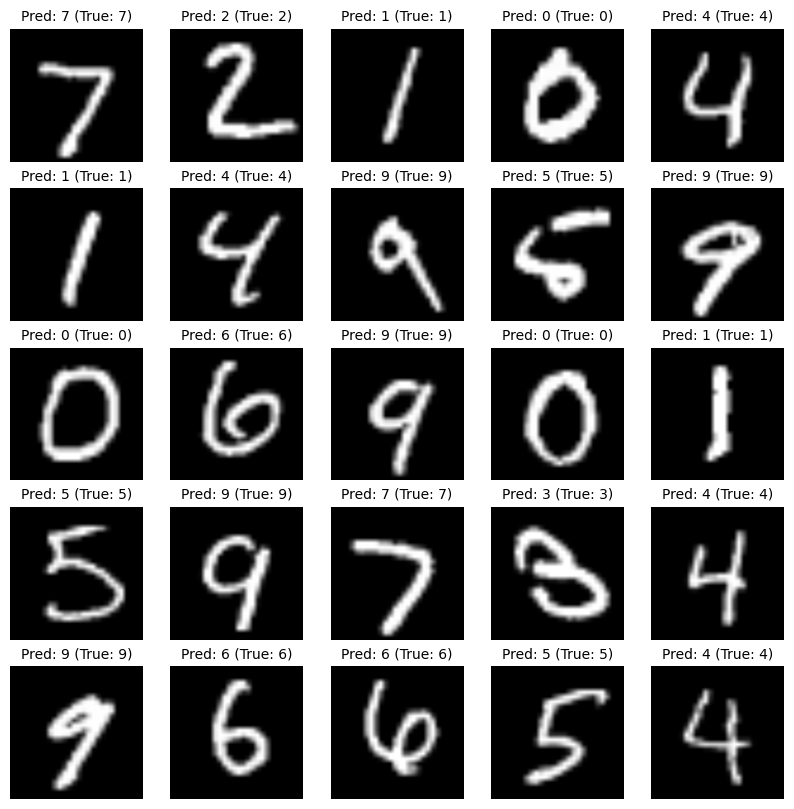

In [16]:
def imshow_grid(inputs, labels, preds=None, title=None):
    # Unnormalize the images
    mean = np.array([0.5])
    std = np.array([0.5])
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    inputs = std * inputs + mean
    inputs = np.clip(inputs, 0, 1)

    fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # Set the grid to 5 rows and 5 columns
    for i, ax in enumerate(axes.flat):
        ax.imshow(inputs[i].squeeze(), cmap='gray')  # Squeeze to display grayscale images
        if preds is not None:
            ax.set_title(f'Pred: {preds[i]} (True: {labels[i]})', fontsize=10)
        else:
            ax.set_title(f'True: {labels[i]}', fontsize=10)
        ax.axis('off')

    if title is not None:
        plt.suptitle(title, fontsize=16)
    plt.show()

# Visualize predictions in a grid
def visualize_predictions(model, dataloader, num_images=25):
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Display a grid of 25 images
            imshow_grid(inputs.cpu().data[:25], labels.cpu().numpy()[:25], preds.cpu().numpy()[:25])

            images_so_far += num_images
            if images_so_far >= num_images:
                break

# Visualize the predictions on test data
visualize_predictions(model_ft, test_loader)